In [182]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision.datasets import MNIST
from tqdm import tqdm
from IPython.display import clear_output

In [183]:
def download_mnist(is_train: bool):
    dataset = MNIST(root='./data',
                    transform=lambda x: np.array(x).flatten() / 255.0,
                    download=True,
                    train=is_train)
    mnist_data = []
    mnist_labels = []
    for image, label in dataset:
        mnist_data.append(image)
        ohl = np.zeros(10)
        ohl[label] = 1
        mnist_labels.append(ohl)
        
    return np.array(mnist_data).T, np.array(mnist_labels).T

train_X, train_Y = download_mnist(True)
train_Y = np.argmax(train_Y, axis=0)  # Convert one-hot encoded labels to class labels
test_X, test_Y = download_mnist(False)
test_Y = np.argmax(test_Y, axis=0)  # Convert one-hot encoded labels to class labels


In [184]:
def init_params():
    W1 = np.random.randn(100, 784) * 0.01
    b1 = np.zeros((100, 1))
    W2 = np.random.randn(10, 100) * 0.01
    b2 = np.zeros((10, 1))

    return W1, b1, W2, b2

In [185]:
def relu(z):
    return np.maximum(0, z)


In [186]:
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)
    # return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)


In [187]:
def forward_propagation(X, W1, b1, W2, b2):
    Z1 = W1.dot(X) + b1                 # (100, 784) * (784, 60000) + (100, 1) = (100, 60000)
    A1 = relu(Z1)                       # (100, 60000)
    Z2 = W2.dot(A1) + b2                # (10, 100) * (100, 60000) + (10, 1) = (10, 60000)
    A2 = softmax(Z2)                    # (10, 60000)
    
    return Z1, A1, Z2, A2


In [188]:
def one_hot(y):
    y = y.astype(int)
    one_hot_y = np.zeros((y.size, y.max() + 1)) 
    one_hot_y[np.arange(y.size), y] = 1
    return one_hot_y.T


In [189]:
def back_propagation(z1, a1, a2, w1, w2, batch_input, y):
    m = y.size
    one_hot_y = one_hot(y) # (10, 60000) 

    dz2 = a2 - one_hot_y                                                 # dz2 is the difference between prediction and truth. (10, 60000)
    dw2 = 1 / m * dz2.dot(a1.T)                                          # dw2 is the gradient for w2. (10, 100)
    db2 = 1 / m * np.sum(dz2, axis=1, keepdims=True)                     # db2 is the gradient for b2. (10, 1)
    dz1 = w2.T.dot(dz2) * relu(z1)                                       # dz1 is the gradient for z1. (100, 60000)
    dw1 = 1 / m * dz1.dot(batch_input.T)                                 # dw1 is the gradient for w1. (100, 784)
    db1 = 1 / m * np.sum(dz1, axis=1, keepdims=True)                     # db1 is the gradient for b1. (100, 1)

    return dw1, db1, dw2, db2

In [190]:
def update_params(w1, b1, w2, b2, dw1, db1, dw2, db2, learning_rate):
    w1 = w1 - learning_rate * dw1
    b1 = b1 - learning_rate * db1
    w2 = w2 - learning_rate * dw2
    b2 = b2 - learning_rate * db2

    return w1, b1, w2, b2


In [191]:
def accuracy(a2, y):
    return np.mean(np.argmax(a2, axis=0) == y)


In [197]:
def evaluate_model(test_X, test_Y, w1, b1, w2, b2):
    _, _, _, a2 = forward_propagation(test_X, w1, b1, w2, b2)
    predictions = np.argmax(a2, axis=0)
    misclassified_indices = np.where(predictions != test_Y)[0]
    test_accuracy = accuracy(a2, test_Y)
    return test_accuracy, misclassified_indices


In [200]:
def gradient_descent_with_lr_scheduler(x, y, epochs, target_accuracy, initial_learning_rate, batch_size, patience, decay_factor):
    w1, b1, w2, b2 = init_params()
    learning_rate = initial_learning_rate
    best_accuracy = 0
    epochs_without_improvement = 0

    for epoch in tqdm(range(epochs)):
        accuracies = []
        for start in range(0, x.shape[1], batch_size):
            end = start + batch_size

            batch_input = x[:, start:end]
            batch_target = y[start:end]

            z1, a1, z2, a2 = forward_propagation(batch_input, w1, b1, w2, b2)
            dw1, db1, dw2, db2 = back_propagation(z1, a1, a2, w1, w2, batch_input, batch_target)
            w1, b1, w2, b2 = update_params(w1, b1, w2, b2, dw1, db1, dw2, db2, learning_rate)

            batch_accuracy = accuracy(a2, batch_target)
            accuracies.append(batch_accuracy)

        train_accuracy = np.mean(accuracies)
        test_accuracy, _ = evaluate_model(test_X, test_Y, w1, b1, w2, b2)
        
        if epoch % 5 == 0:
            clear_output(wait=True)
            print('Learning rate:', learning_rate)
            print('Iteration:', epoch)
            print('Train accuracy:', train_accuracy * 100, '%')
            print('Test accuracy:', test_accuracy * 100, '%')

        if train_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience and learning_rate > 0.0001:
            learning_rate *= decay_factor
            print(f'Learning rate decayed to {learning_rate}')
            epochs_without_improvement = 0

        if test_accuracy >= target_accuracy:
            print('Target accuracy reached. Stopping training.')
            break

    return w1, b1, w2, b2

In [194]:
target_accuracy = 0.99
max_iterations = 100
initial_learning_rate = 0.25
batch_size = 100
patience = 5
decay_factor = 0.5

w1, b1, w2, b2 = gradient_descent_with_lr_scheduler(train_X, train_Y, max_iterations, target_accuracy, initial_learning_rate, batch_size, patience, decay_factor)

Learning rate: 0.0001220703125
Iteration: 95
Train accuracy: 99.43666666666668 %
Test accuracy: 97.02 %


 98%|█████████▊| 98/100 [01:53<00:02,  1.06s/it]

Learning rate decayed to 6.103515625e-05


100%|██████████| 100/100 [01:54<00:00,  1.15s/it]


In [195]:
def show_random_misclassified_image(test_X, test_Y, misclassified_indices, predictions):
    if len(misclassified_indices) == 0:
        print("No misclassified images to display.")
        return

    random_index = np.random.choice(misclassified_indices)
    plt.figure(figsize=(5, 5))
    plt.imshow(test_X[:, random_index].reshape(28, 28), cmap='gray')
    plt.title(f'True: {test_Y[random_index]}, Pred: {predictions[random_index]}')
    plt.axis('off')
    plt.show()

# Evaluate the model and get misclassified indices
test_accuracy, misclassified_indices = evaluate_model(test_X, test_Y, w1, b1, w2, b2)
_, _, _, a2 = forward_propagation(test_X, w1, b1, w2, b2)
predictions = np.argmax(a2, axis=0)

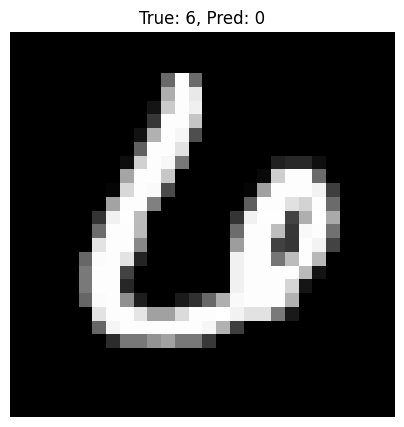

In [203]:
# Show a random misclassified image
show_random_misclassified_image(test_X, test_Y, misclassified_indices, predictions)